In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('C:/Users/jay/TimeSeriesForecastingInPython-master/data/jj.csv')
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


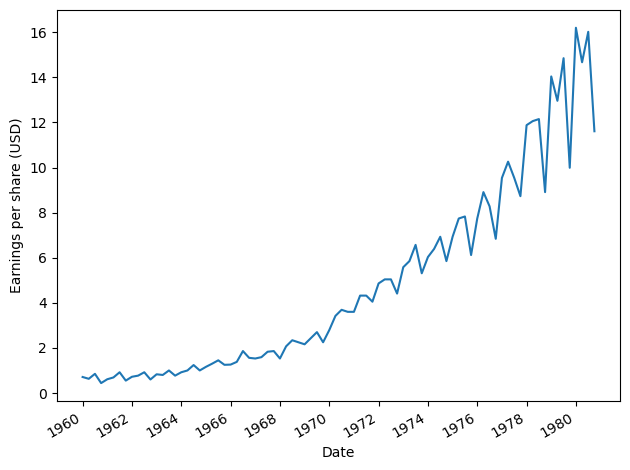

In [5]:
fig, ax = plt.subplots()

ax.plot(df.date, df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [6]:
ad_fuller_result = adfuller(df['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.7420165734574735
p-value: 1.0


In [7]:
eps_diff = np.diff(df['data'], n=1)
ad_fuller_result = adfuller(eps_diff)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.40740976363804116
p-value: 0.9088542416911313


In [8]:
eps_diff2 = np.diff(eps_diff, n=1)
ad_fuller_result = adfuller(eps_diff2)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.585162874793187
p-value: 0.006051099869603033


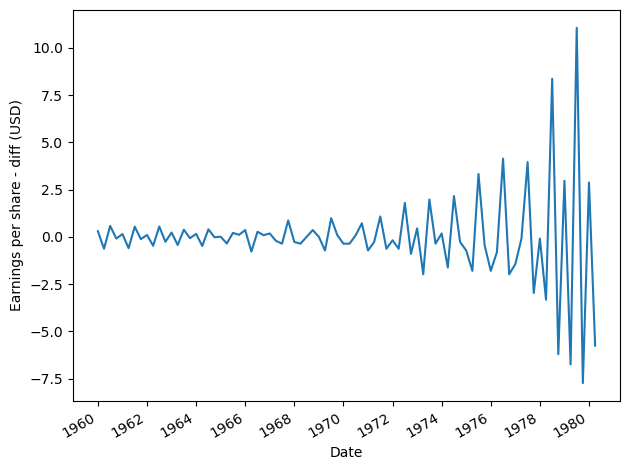

In [11]:
fig, ax = plt.subplots()

ax.plot(df['date'][2:], eps_diff2)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share - diff (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

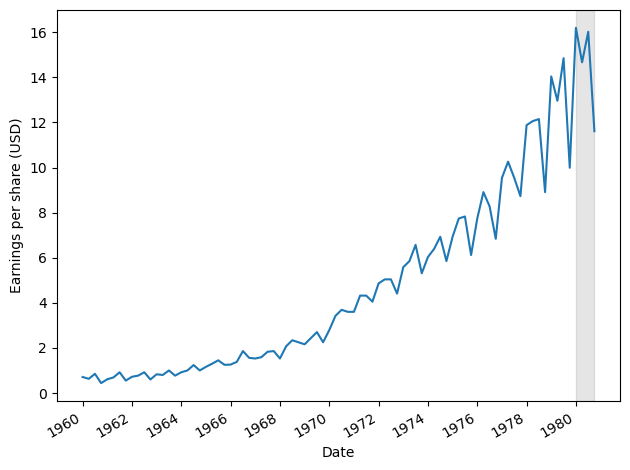

In [12]:
fig, ax = plt.subplots()
ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)
plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [13]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]),
                            simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([order, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    # sort in ascending order, lower aic is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

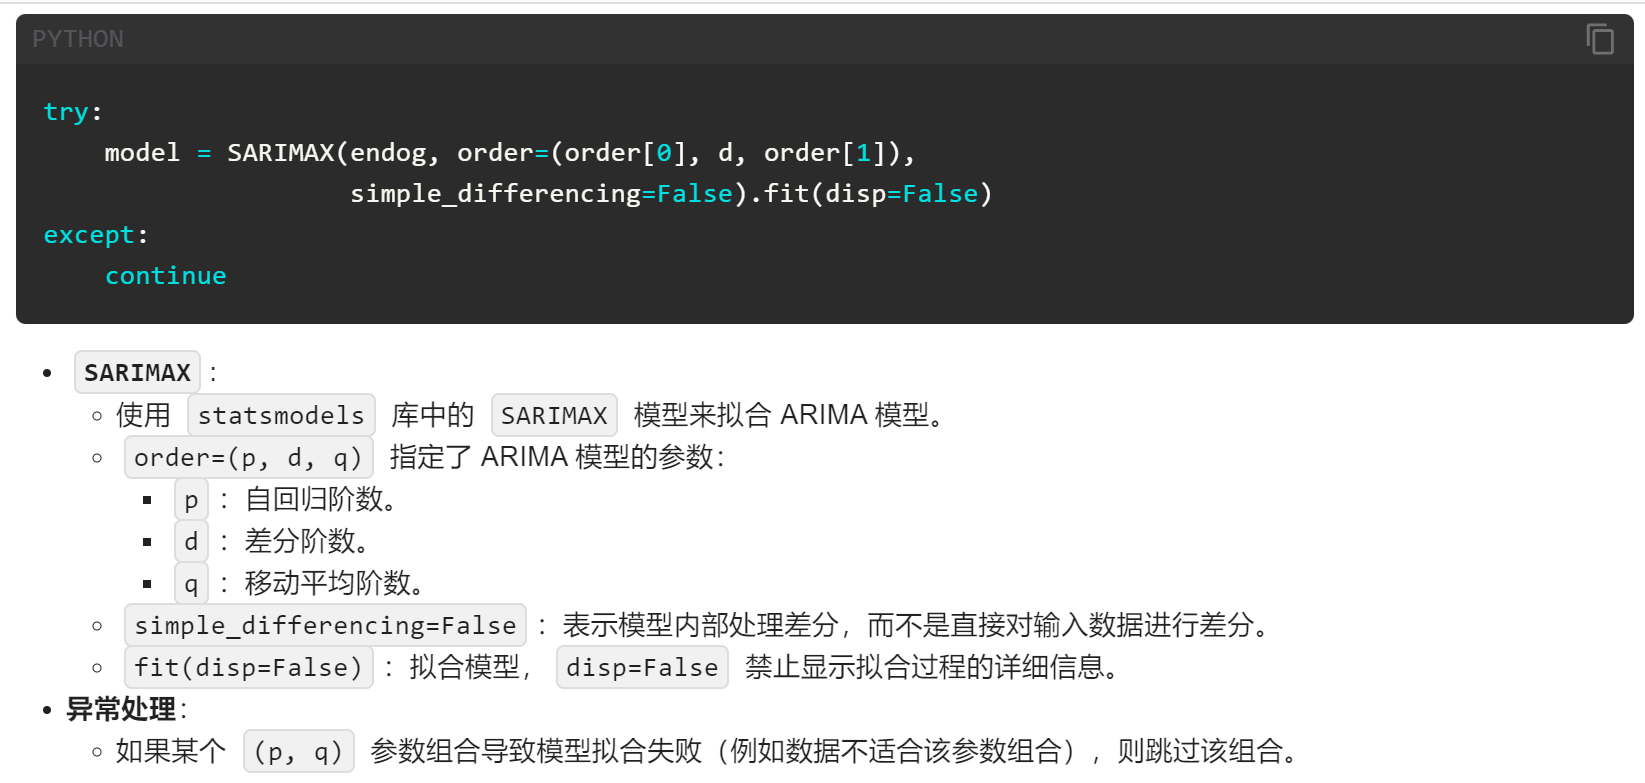

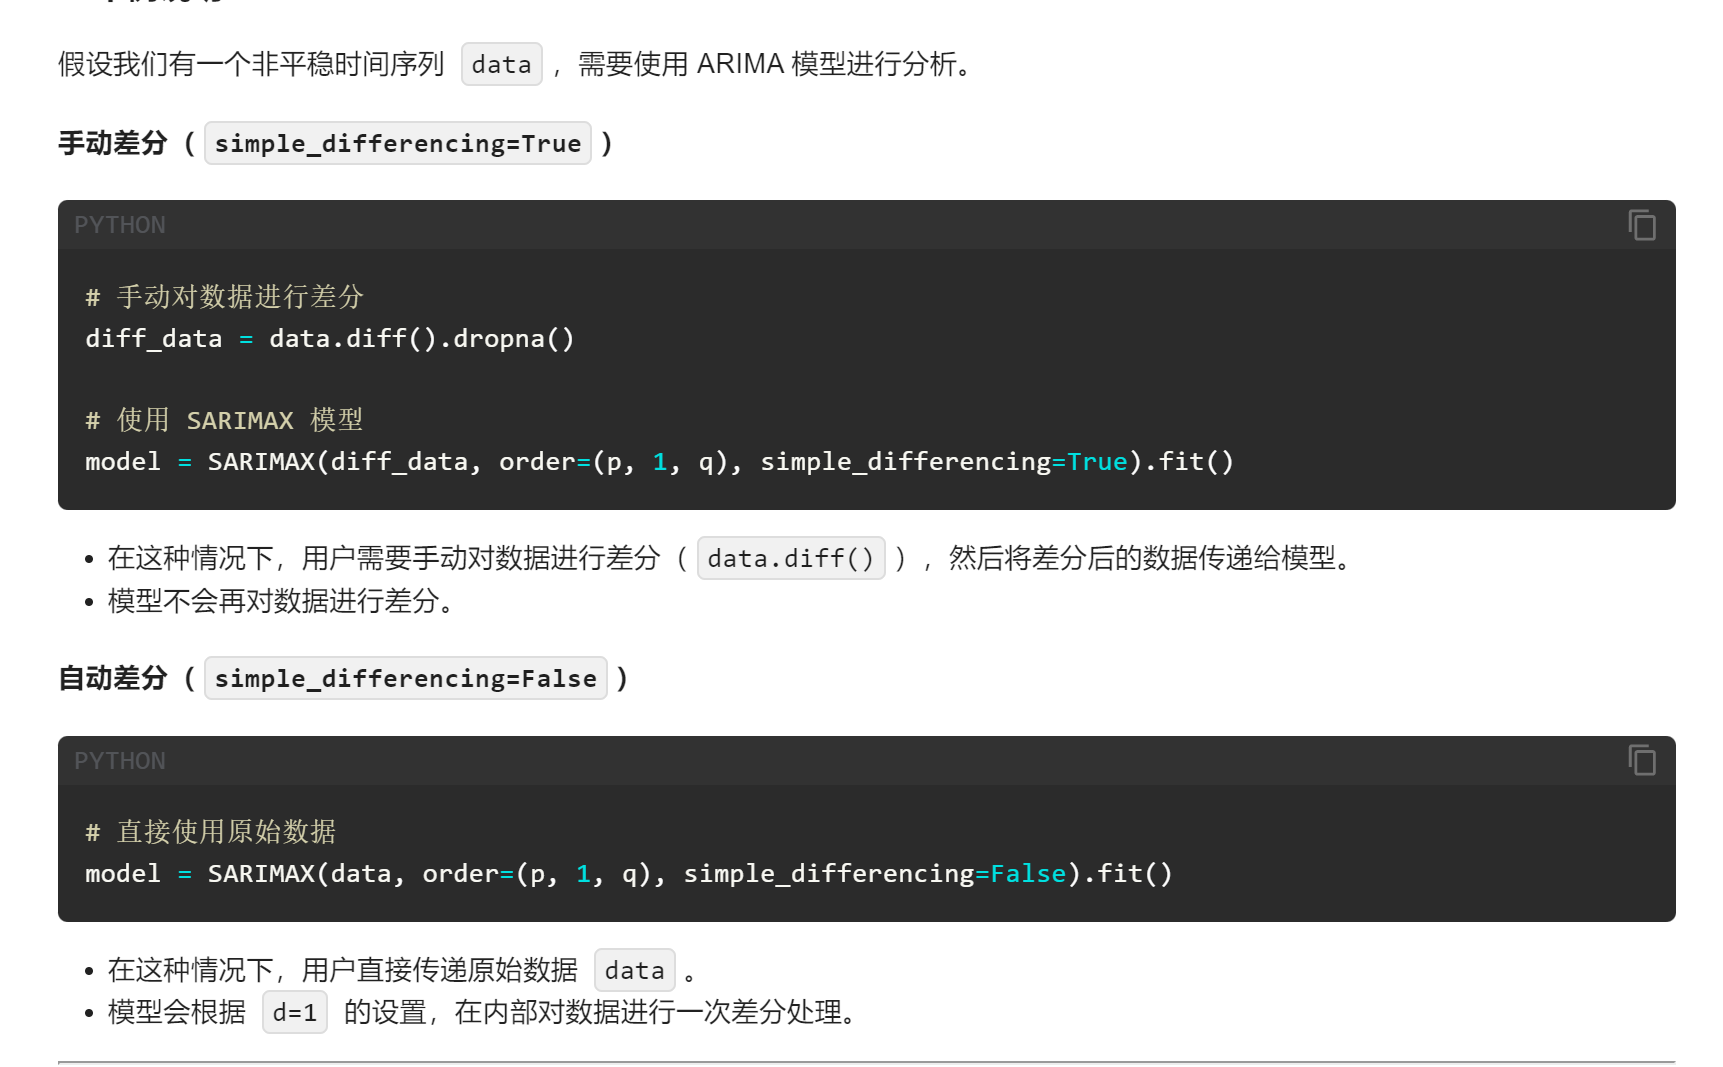

In [14]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 2
order_list = list(product(ps, qs))

In [15]:
train = df['data'][:-4]
result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 3)",115.270491
1,"(3, 1)",115.624980
2,"(3, 2)",115.672006
3,"(3, 0)",154.430644
4,"(0, 3)",194.654716
5,"(0, 2)",209.274658
6,"(2, 3)",220.666758
7,"(1, 3)",228.267706
8,"(1, 2)",228.935799
9,"(2, 2)",229.974672


In [16]:
model = SARIMAX(train, order=(3,2,3), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   80
Model:               SARIMAX(3, 2, 3)   Log Likelihood                 -50.635
Date:                Sun, 04 May 2025   AIC                            115.270
Time:                        21:12:15   BIC                            131.767
Sample:                             0   HQIC                           121.875
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9988      0.037    -26.999      0.000      -1.071      -0.926
ar.L2         -0.9868      0.040    -24.848      0.000      -1.065      -0.909
ar.L3         -0.9752      0.026    -36.954      0.0

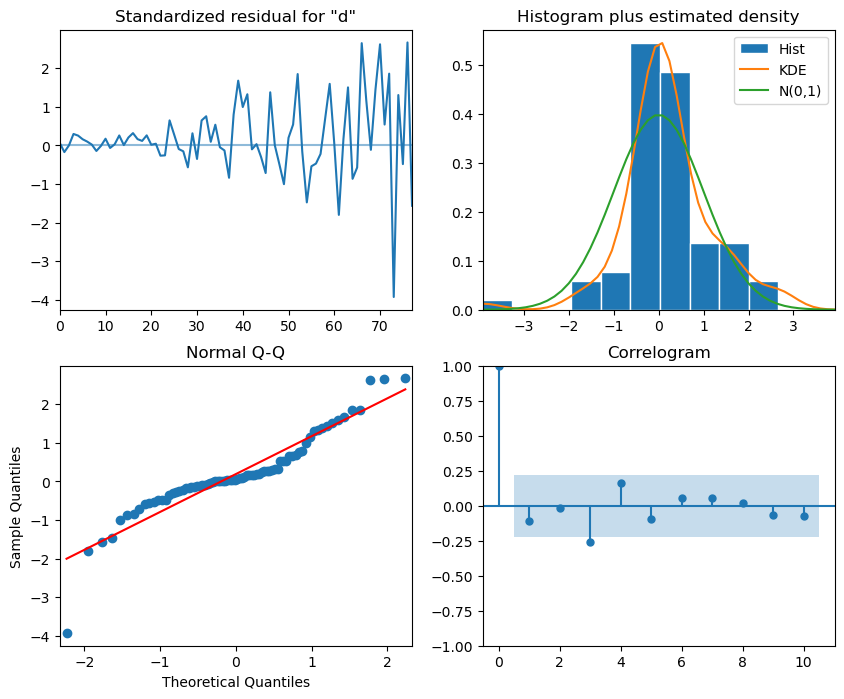

In [17]:
model_fit.plot_diagnostics(figsize=(10,8))

In [18]:
residuals = model_fit.resid

In [19]:
residuals

0     0.710000
1    -0.434997
2     0.299985
3    -0.365174
4     0.002752
        ...   
75   -1.683885
76    0.560679
77   -0.206817
78    1.145270
79   -0.670416
Length: 80, dtype: float64

In [24]:
results = acorr_ljungbox(residuals, lags=np.arange(1,11,1), return_df=True)
print(results['lb_pvalue'])

1     0.204578
2     0.446455
3     0.063511
4     0.056175
5     0.080409
6     0.122306
7     0.171999
8     0.242036
9     0.298085
10    0.347219
Name: lb_pvalue, dtype: float64


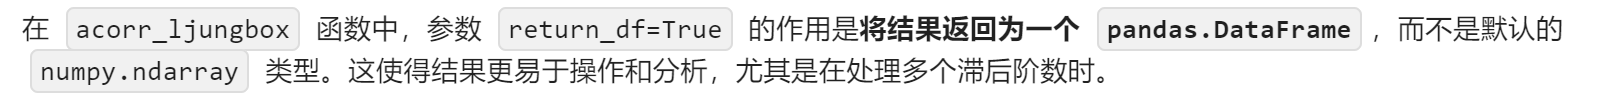

In [25]:
test = df.iloc[-4:]
test['naive_seasonal'] = df['data'].iloc[76:80].values
test

,date,data,naive_seasonal
80,1980-01-01,16.20,14.04
81,1980-04-01,14.67,12.96
82,1980-07-02,16.02,14.85
83,1980-10-01,11.61,9.99


In [27]:
ARIMA_pred = model_fit.get_prediction(80, 83).predicted_mean
test['ARIMA_pred'] = ARIMA_pred
test

,date,data,naive_seasonal,ARIMA_pred
80,1980-01-01,16.20,14.04,15.854267
81,1980-04-01,14.67,12.96,14.382649
82,1980-07-02,16.02,14.85,16.369915
83,1980-10-01,11.61,9.99,11.683267


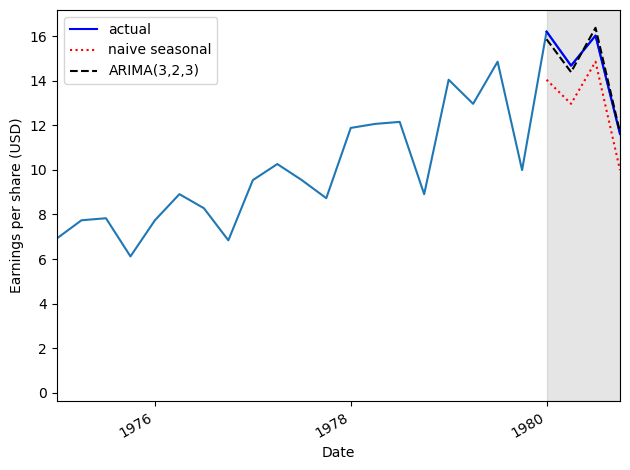

In [29]:
fig, ax = plt.subplots()
ax.plot(df['date'], df['data'])
ax.plot(test['data'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(3,2,3)')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)
ax.legend(loc=2)
plt.xticks(np.arange(0,81,8), 
           [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax.set_xlim(60, 83)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [30]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [31]:
mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_ARIMA = mape(test['data'], test['ARIMA_pred'])
print(mape_naive_seasonal, mape_ARIMA)

11.561658552433654 1.7270572917000082


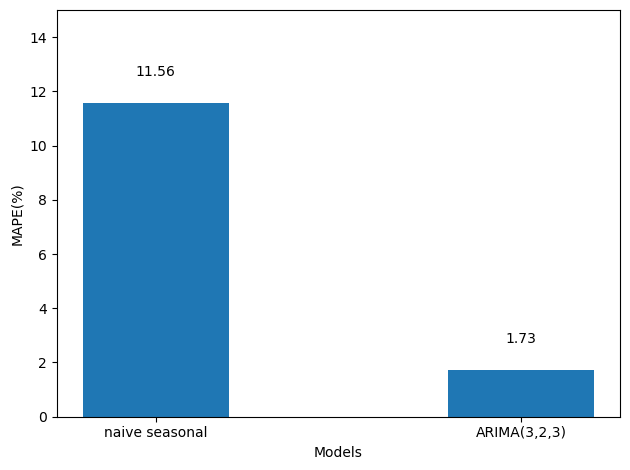

In [32]:
fig, ax = plt.subplots()
x = ['naive seasonal', 'ARIMA(3,2,3)']
y = [mape_naive_seasonal, mape_ARIMA]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE(%)')
ax.set_ylim(0, 15)
for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')
plt.tight_layout()
plt.show()